## Kaggle Competition 1: Titanic

In this Notebook, I will attempt to build a Model that predicts wether a Person has survived the sinking of the Titanic or not, using the well-known Titanic Dataset and my learnings from the first term of my MSc. Business Analytics at ESADE.

In [140]:
#import the necessary packages
import pandas as pd
import numpy as np


# PREPROCESSING & MODEL SELECTION
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score

# PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# STANDARD MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# ENSEMBLE
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# XGBOOST
from xgboost import XGBClassifier

#IGNORE WARNINGS
import warnings
warnings.simplefilter("ignore", UserWarning)


#HYPERPARAMETER TUNING
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#PICKLE TO EXPORT THE MODEL
from pickle import dump
from pickle import load

In [29]:
#Load the training Dataset
df = pd.read_csv('train.csv',header=0)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
#observe the dataset and check the consistency
df.info()

# see how many null values we have and if there are too many in a column think about filling them or dropping
print(df.isnull().sum()/len(df))

#see if we have any dummy variables or categoricals
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64


PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [32]:
# get rid of cabin, as it has too many NaN, and predictor variables that dont contain information 
df = df.drop(["Cabin", "Name", "Ticket", "PassengerId"], 1)

#Fill NaN for age with the mean
df["Age"] = df["Age"].fillna(df["Age"].mean())

['S' 'C' 'Q']


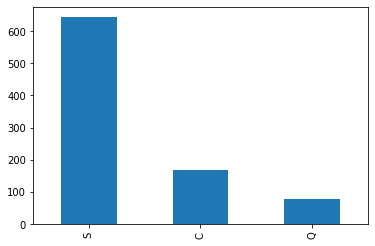

In [33]:
#what to do with the NaN in Embarked?
df['Embarked'].value_counts().plot(kind='bar')

#seems like a safe bet to place them into "S"
df["Embarked"] = df["Embarked"].fillna("S")
print(df['Embarked'].unique())

In [34]:
#transform non-numerical data to categorical and Dummies

for column in df.select_dtypes('object'):
    if len(df[column].unique()) == 2:
        df[column] = pd.get_dummies(df[column], dtype='int64')
    else:
        df = pd.get_dummies(df, prefix=column, columns=[column], drop_first=True, dtype='int64')



In [36]:
df = df.dropna()
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,1
1,1,1,1,38.0,1,0,71.2833,0,0
2,1,3,1,26.0,0,0,7.9250,0,1
3,1,1,1,35.0,1,0,53.1000,0,1
4,0,3,0,35.0,0,0,8.0500,0,1


## Feature Extraction

In [47]:
# add a Dummy for Children below 21
df['Child'] = [1 if x <= 21 else 0 for x in df['Age']]
df.Child.sum()

204

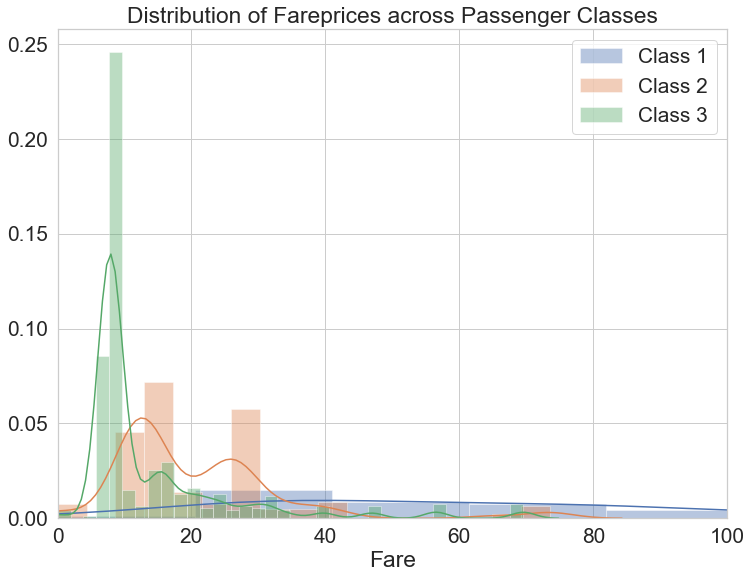

In [68]:
# Does it make sense to split Fare into Classes? Or are they going to be collinear with Pclass?
class1 = df.loc[df['Pclass']==1]
class2 = df.loc[df['Pclass']==2]
class3 = df.loc[df['Pclass']==3]

plt.figure(figsize=(12,9))
plt.xlim(0,100)
plt.title("Distribution of Fareprices across Passenger Classes")
sns.distplot(class1["Fare"], label= "Class 1")
sns.distplot(class2["Fare"], label= "Class 2")
sns.distplot(class3["Fare"], label= "Class 3")
plt.legend()

# You can clearly see that there is no clear categorisation in terms of price of tickets possible

In [73]:
# we can get the total number of relatives on the Titanic through adding SibSp and Parch + oneself
df['# of Rel'] = df["SibSp"]+df["Parch"]+1
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Child,# of Rel
0,0,3,0,22.0,1,0,7.2500,0,1,0,2
1,1,1,1,38.0,1,0,71.2833,0,0,0,2
2,1,3,1,26.0,0,0,7.9250,0,1,0,1
3,1,1,1,35.0,1,0,53.1000,0,1,0,2
4,0,3,0,35.0,0,0,8.0500,0,1,0,1


In [96]:
# we can enter a variable that shows priority to leave the boat from Women and Children
def f(x):
    if x['Child'] == 1:
        val = 1
    elif x['Sex'] == 1:
        val = 1
    else:
        val = 0
    return val

df["Priority"] = df.apply(f, axis=1)

## Match the Features in the Test Set

In [97]:
test = pd.read_csv('test.csv',header=0)
test = test.drop(["Cabin", "Name", "Ticket", "PassengerId"], 1)
test["Age"] = test["Age"].fillna(df["Age"].mean())
test["Embarked"] = test["Embarked"].fillna("S")
test['Child'] = [1 if x <= 21 else 0 for x in test['Age']]
test['# of Rel'] = test["SibSp"]+df["Parch"]+1
test["Priority"] = test.apply(f,axis=1)

## Split the Data into Y and X and test rescaling features in combination with models

In [100]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,Child,# of Rel,Priority
0,0,3,0,22.0,1,0,7.2500,0,1,0,2,0
1,1,1,1,38.0,1,0,71.2833,0,0,0,2,1
2,1,3,1,26.0,0,0,7.9250,0,1,0,1,1
3,1,1,1,35.0,1,0,53.1000,0,1,0,2,1
4,0,3,0,35.0,0,0,8.0500,0,1,0,1,0


In [126]:
# split the Dataset into X and Y

X = df.drop("Survived",1).values
y = df["Survived"].values

# first we will check, whch sort of recaling will improve the accuracy of the model the most, 
# hence I will run a loop across all models and see, which methods deals with the distribution of the dataset the best

def evaluate_classifiers(X, y, n_splits=10, shuffle=True, random_state=3):
    X_std = StandardScaler().fit_transform(X)
    X_minmax = MinMaxScaler().fit_transform(X)
    
    features = [('Normal',       X), 
                ('Standardized', X_std), 
                ('MinMax',       X_minmax)]
    
    models = [('LogisticRegression',         LogisticRegression(solver="liblinear")),
              ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
              ('KNeighborsClassifier',       KNeighborsClassifier()),
              ('Naive Bayes',                GaussianNB()),
              ('DecisionTreeClassifier',     DecisionTreeClassifier()),
              ('SupportVectorMachine',       SVC(gamma="scale"))]
    
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    results = []
    for model in models:
        
        for feature in features:
            res = cross_val_score(model[1], feature[1], y, cv=kfold)
            
            [results.append((model[0], feature[0], model[0]+'_'+feature[0], r)) for r in res]
    
    results = pd.DataFrame(results, columns=['Model', 'FeatureScaling', 'Combined', 'Result'])
    return results



Titanic Results:
                                           Result
Combined                                         
DecisionTreeClassifier_MinMax            0.777728
DecisionTreeClassifier_Normal            0.769900
DecisionTreeClassifier_Standardized      0.779963
KNeighborsClassifier_MinMax              0.791236
KNeighborsClassifier_Normal              0.712734
KNeighborsClassifier_Standardized        0.801361
LinearDiscriminantAnalysis_MinMax        0.795730
LinearDiscriminantAnalysis_Normal        0.795730
LinearDiscriminantAnalysis_Standardized  0.795730
LogisticRegression_MinMax                0.805830
LogisticRegression_Normal                0.806966
LogisticRegression_Standardized          0.809226
Naive Bayes_MinMax                       0.796841
Naive Bayes_Normal                       0.796841
Naive Bayes_Standardized                 0.796841
SupportVectorMachine_MinMax              0.806941
SupportVectorMachine_Normal              0.684682
SupportVectorMachine_Standardized

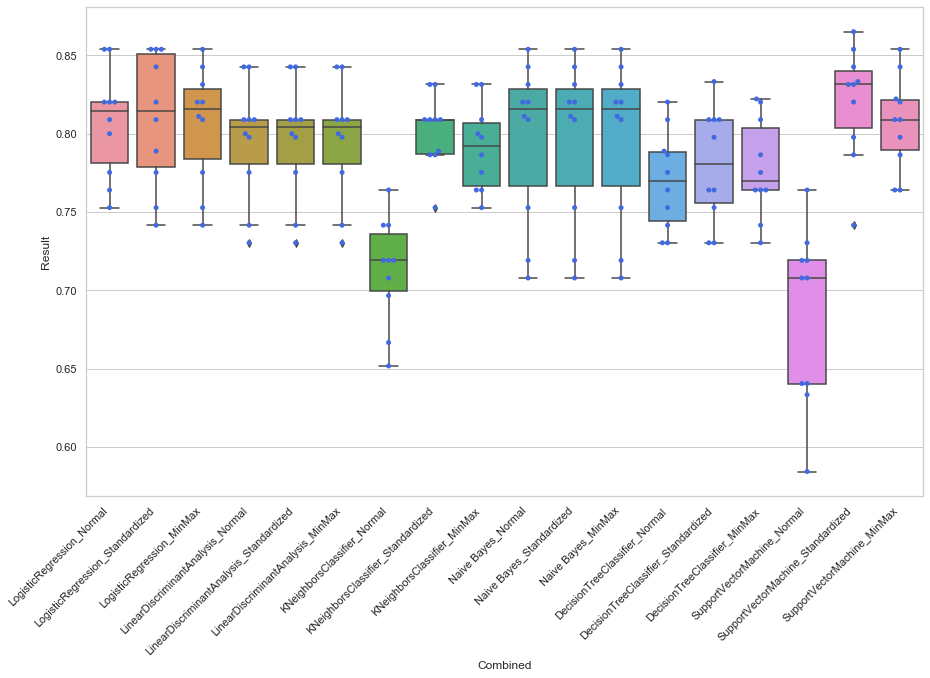

In [137]:
results = evaluate_classifiers(X, y)

plt.figure(figsize=(15,9))
chart = sns.boxplot(data=results, x='Combined', y='Result')
chart = sns.swarmplot(data=results, x='Combined', y='Result', color="royalblue")
chart.set_xticklabels(labels=results['Combined'].unique(), rotation=45, horizontalalignment='right')

print('Titanic Results:')
print(results.groupby("Combined").mean())

#which one is the best model based on this?
#Average: the higher the mean, the better the model
#Standard Deviation of KFolds: the lower the variance, the better

## Ensembles and XGBoost

In [119]:
# We can see that a standardised supportvector machine performs very well and that most models seem to be scoring around the 80%
# this is quite good, but lets see if ensembles are able to improve on these results

# I will apply the same method as before in order to compare the models

def evaluate_ensembles(X, y, max_features=10, n_estimators=50, n_splits=10, shuffle=True, random_state=3):
    models = [
        ('BaggingClassifier',          BaggingClassifier(n_estimators=n_estimators,
                                                         max_features=max_features, 
                                                         random_state=random_state)),
        
        ('RandomForestClassifier',     RandomForestClassifier(n_estimators=n_estimators, 
                                                              max_features=max_features, 
                                                              random_state=random_state)),
        
        ('ExtraTreesClassifier',       ExtraTreesClassifier(n_estimators=n_estimators, 
                                                            max_features=max_features, 
                                                            random_state=random_state)),
        
        ('AdaBoostClassifier',         AdaBoostClassifier(n_estimators=n_estimators, 
                                                          random_state=random_state)),
        
        ('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=n_estimators, 
                                                                  max_features=max_features, 
                                                                  random_state=random_state)),
        ('XGBoost Classifier',         XGBClassifier(n_estimators=n_estimators, 
                                                                  max_features=max_features, 
                                                                  random_state=random_state))]

    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    results = []
    for model in models:
        res = cross_val_score(model[1], X, y, cv=kfold)
        [results.append((model[0], r)) for r in res]
    
    results = pd.DataFrame(results, columns=['Model', 'Result'])
    return results

Titanic Dataset Results:
                              Result
Model                               
AdaBoostClassifier          0.804719
BaggingClassifier           0.824919
ExtraTreesClassifier        0.787890
GradientBoostingClassifier  0.821536
RandomForestClassifier      0.819301
XGBoost Classifier          0.819288


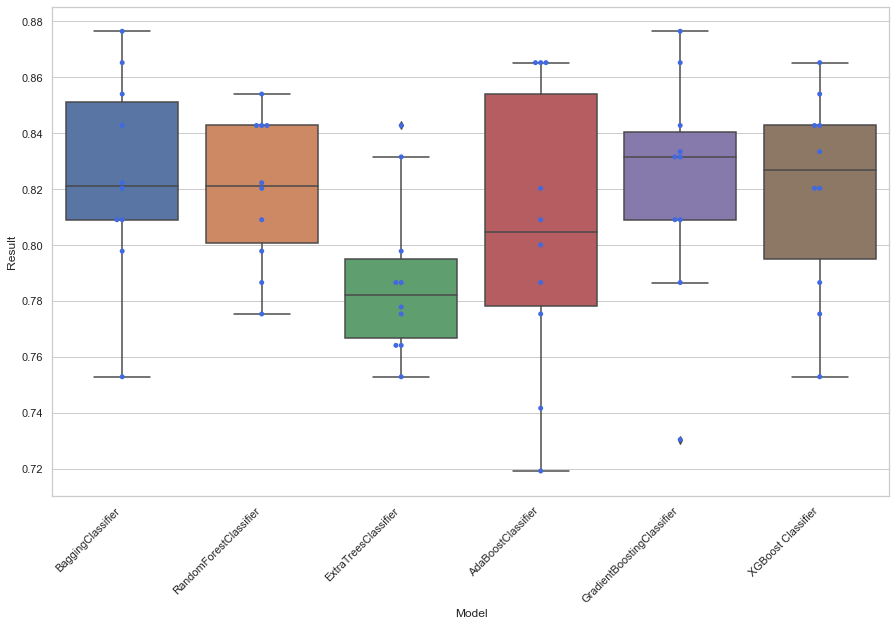

In [152]:
# to avoid overfitting, I specified a few different max_features and it turns out that 5 features seem to be optimal
results = evaluate_ensembles(X, y, max_features=5)

plt.figure(figsize=(15,9))
chart = sns.boxplot(data=results, x='Model', y='Result')
chart = sns.swarmplot(data=results, x='Model', y='Result', color="royalblue")
chart.set_xticklabels(labels=results['Model'].unique(), rotation=45, horizontalalignment='right')

print('Titanic Dataset Results:')
print(results.groupby("Model").mean())

In [ ]:
# Using an Ensemble Algorithm, and validating the model using KFold, it appears that Bagging works best, however it does have
# a larger std than GradientBoosting

# another option would be to use a support vector machine, after Standardising the Features

# However, since retraining is not too important and there is no more new data coming, I will chose Bagging

## Hyperparameter tuning the Ensemble

In [138]:
# I will be using a Randomized Grid Search to tune the Hyperparameters

In [151]:
BaggingClassifier().get_params().keys()

dict_keys(['base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [154]:
model = BaggingClassifier()
kfold = KFold(n_splits=10, shuffle=True, random_state=3)

param_grid={"max_features": randint(1,8) , "n_estimators": randint(50,300)}

model=BaggingClassifier()
grid=RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=kfold, random_state=3)
grid.fit(X,y)

# the default score is accuracy 

print(f'Grid Best Score {grid.best_score_*100:.5f} N. of features  {grid.best_estimator_.max_features:.3f} \
            N. of tress {grid.best_estimator_.n_estimators:3d}')

Grid Best Score 84.28732 N. of features  6.000             N. of tress 156


In [ ]:
# after boosting I am able to improve the accuracy of the model to 84.3%, which is the 
# best I am able to achieve with the current set of features 

## Save the model and run it on the test set

In [157]:
# # last step is to save the model using pickle
# model =BaggingClassifier(max_features=6, n_trees=156, random_state=3)

# # Now we save it into a file
# filename="Titanic_model_v1.sav"
# dump(model, open(filename, "wb"))

TypeError: __init__() got an unexpected keyword argument 'n_trees'

In [156]:
# #load the model from disk
# loaded_model=load(open(filename, "rb"))

# # fit the model on the test DataSet and get results
# result=loaded_model.score(X_test,y_test)

# print(f'Loaded model - Accuracy {result.mean()*100:.3f}% ')

TypeError: __init__() got an unexpected keyword argument 'n_samples'